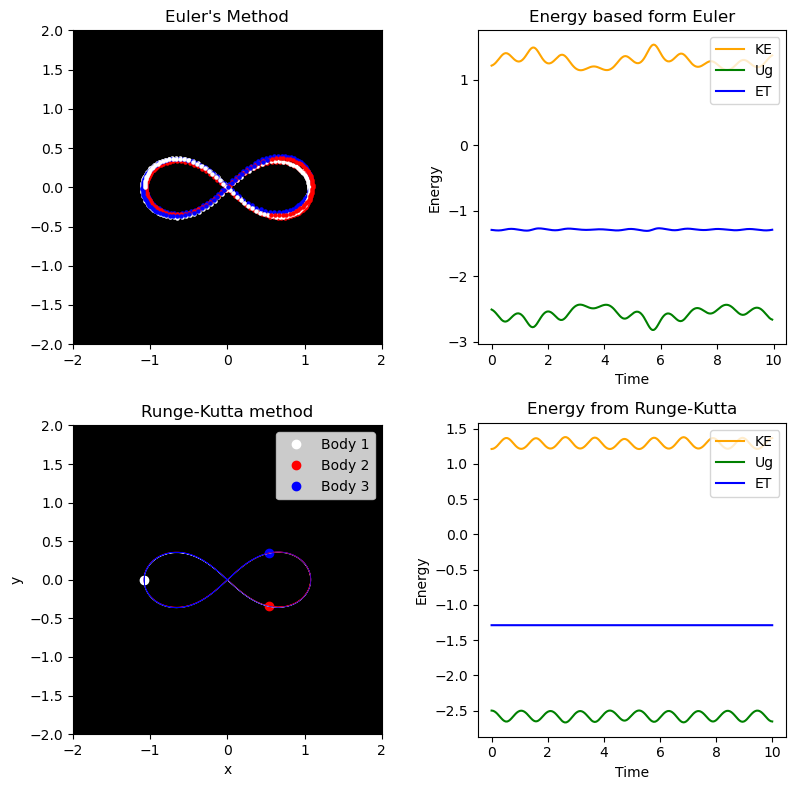

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import display, clear_output
import time

# Fixed values for gravitational constant and masses
G = 1.0
m1, m2, m3 = 1.0, 1.0, 1.0

class Planet:
    """
    Planet object has no methods, as they rely on each other to move. Attributes: mass, position (time-dependent), position (time-dependent), 
    radius (for collision handling), velocity (time-dependent). Each 2D quantity should be initialized as a np.array or a tuple.
    """
    def __init__(self, mass, pos, radius=0.1, v=[0, 0]):
        self.mass = mass
        self.pos = np.array(pos, dtype=float)
        self.v = np.array(v, dtype=float)
        self.radius = radius

def gravity_acceleration(planet1, planet2):
    """
    Calculates the acceleration vector (ax,ay) as calculated from planet 1 by planet 2. To get the newtonian pair, reverse the order of the args.
    """
    d = planet2.pos - planet1.pos #displacement vector
    r = np.linalg.norm(d) #radial distance
    if r <= (planet1.radius + planet2.radius):
        raise ValueError('Collision has occurred!')
    magnitude = (G * planet1.mass * planet2.mass) / r**2
    vector = magnitude * d / r #magnitude in the direction of the unit vector d/r
    a = vector / planet1.mass
    return a

def update_position(planet, dt):
    """
    Euler's method update of the position of a plent using a dt
    """
    planet.pos += planet.v * dt

def KE(planets):
    """
    Simple kinetic energy (scalar) calculation and requires planet list as argument
    """
    return sum(0.5 * planet.mass * np.linalg.norm(planet.v)**2 for planet in planets)

def U(planets):
    """
    Requires planet list as argument. Simple gravitational potential energy calculation
    """
    return sum(
        -G * planets[i].mass * planets[j].mass / np.linalg.norm(planets[i].pos - planets[j].pos) #-Gmm/r
        for i in range(len(planets)) for j in range(i + 1, len(planets))
    )

def three_body_eq(t, y, G, m1, m2, m3):
    """
    A presentation of the 3 coupled differential equations for solving using solve_ivp method.
    """
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return [vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3]

def setup(planetList):
    """
    A required function taking a list of planets and returning 4 axes with the positions initialized. This function must be run before animate.
    Animate takes these outputted axes as parameters.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
    
    ax1.set_ylim((-2, 2))
    ax1.set_xlim((-2, 2))
    ax1.set_title("Euler's Method")
    ax1.set_facecolor('black')

    ax2.set_title('Energy form Euler')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Energy')
    ax2.set_ylim((-1000, 1000))
    ax2.set_xlim((0, 100))
    ax2.legend(['KE', 'Ug', 'ET'], loc='upper right')

    ax3.set_title("Runge-Kutta method")
    ax3.set_xlim(-2, 2)
    ax3.set_ylim(-2, 2)
    ax3.set_aspect('equal')
    ax3.set_facecolor('black')

    ax4.set_title('Energy from Runge-Kutta')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Energy')
    ax4.set_ylim((-1000, 1000))
    ax4.set_xlim((0, 100))
    ax4.legend(['KE', 'Ug', 'ET'], loc='upper right')
    plt.tight_layout() 
    return fig, ax1, ax2, ax3, ax4

def animate(planet1, planet2, planet3, dt, iterations):
    """
    The chief function takes 3 planets, a time step, and a number of iterations, and produces an animation of the 3 body problem with the
    specified initial conditions for {iterations} number of {dt} time steps. It graphs Euler's method, the energy plots of Euler's method, as 
    well as the animation for Runge-Kutta 4th order animation and energy plots.
    """
    fig, ax1, ax2, ax3, ax4 = setup([planet1, planet2, planet3])
    kinetic = []
    potential = []
    # initial values found from here: http://three-body.ipb.ac.rs/sol.php?id=1
    x1, y1 = 0.970, 0.243
    x2, y2 = -0.970, -0.243
    x3, y3 = 0.0, 0.0
    vx1, vy1 = 0.466, -0.432
    vx2, vy2 = 0.466, -0.432
    vx3, vy3 = -2 * 0.466, 2 * 0.432
    y0 = [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]

    computed_kinetic = []
    computed_potential = []
    t_span = (0, 10)
    t_eval = np.linspace(*t_span, 200)

    solution = solve_ivp(three_body_eq, t_span, y0, args=(G, m1, m2, m3), t_eval=t_eval, rtol=1e-9)
    x1_sol, y1_sol = solution.y[0], solution.y[1]
    x2_sol, y2_sol = solution.y[2], solution.y[3]
    x3_sol, y3_sol = solution.y[4], solution.y[5] #using solve-ivp (RK4)

    for iteration in range(iterations): #animation begins
        a12 = gravity_acceleration(planet1, planet2)
        a21 = gravity_acceleration(planet2, planet1)
        a13 = gravity_acceleration(planet1, planet3)
        a31 = gravity_acceleration(planet3, planet1)
        a23 = gravity_acceleration(planet2, planet3)
        a32 = gravity_acceleration(planet3, planet2)

        planet1.v += (a12 + a13) * dt #EULER'S METHOD
        planet2.v += (a21 + a23) * dt
        planet3.v += (a31 + a32) * dt

        update_position(planet1, dt)
        update_position(planet2, dt)
        update_position(planet3, dt)

        #ax1.set_facecolor('black')
        
        #ax1.set_title('3-body problem')
        #ax1.set_xlim(-2, 2)
        #ax1.set_ylim(-2, 2)
        ax1.scatter(planet1.pos[0], planet1.pos[1], color='white', s=planet1.radius * 50)
        ax1.scatter(planet2.pos[0], planet2.pos[1], color='red', s=planet2.radius * 50)
        ax1.scatter(planet3.pos[0], planet3.pos[1], color='blue', s=planet3.radius * 50)

        Kt = KE([planet1, planet2, planet3])
        Ut = U([planet1, planet2, planet3])
        kinetic.append(Kt)
        potential.append(Ut)

        ax2.clear()
        ax2.plot(np.arange(iteration + 1) * dt, kinetic, label='KE', c='orange')
        ax2.plot(np.arange(iteration + 1) * dt, potential, label='Ug', c='g')
        ax2.plot(np.arange(iteration + 1) * dt, np.array(kinetic) + np.array(potential), label='ET', c='b')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Energy')
        ax2.set_title('Energy based form Euler')
        ax2.legend(loc='upper right')

        ax3.clear()
        ax3.set_xlim(-2, 2)
        ax3.set_ylim(-2, 2)
        ax3.set_aspect('equal')

        ax3.plot(x1_sol[iteration], y1_sol[iteration], 'wo', label="Body 1")
        ax3.plot(x2_sol[iteration], y2_sol[iteration], 'ro', label="Body 2")
        ax3.plot(x3_sol[iteration], y3_sol[iteration], 'bo', label="Body 3")

        ax3.plot(x1_sol[:iteration], y1_sol[:iteration], 'w-', lw=0.5)
        ax3.plot(x2_sol[:iteration], y2_sol[:iteration], 'r-', lw=0.5)
        ax3.plot(x3_sol[:iteration], y3_sol[:iteration], 'b-', lw=0.5)

        ax3.legend()
        ax3.set_title("Runge-Kutta method")
        ax3.set_xlabel("x")
        ax3.set_ylabel("y")

        v1 = np.array([solution.y[6, iteration], solution.y[7, iteration]])
        v2 = np.array([solution.y[8, iteration], solution.y[9, iteration]])
        v3 = np.array([solution.y[10, iteration], solution.y[11, iteration]])
        Kt_computed = 0.5 * (m1 * np.linalg.norm(v1)**2 + m2 * np.linalg.norm(v2)**2 + m3 * np.linalg.norm(v3)**2)
        Ut_computed = U([Planet(m1, [x1_sol[iteration], y1_sol[iteration]]),
                         Planet(m2, [x2_sol[iteration], y2_sol[iteration]]),
                         Planet(m3, [x3_sol[iteration], y3_sol[iteration]])])

        computed_kinetic.append(Kt_computed)
        computed_potential.append(Ut_computed)

        ax4.clear()
        ax4.plot(t_eval[:iteration + 1], computed_kinetic, label='KE', color='orange')
        ax4.plot(t_eval[:iteration + 1], computed_potential, label='Ug', color='green')
        ax4.plot(t_eval[:iteration + 1], np.array(computed_kinetic) + np.array(computed_potential), label='ET', color='blue')
        ax4.set_title('Energy from Runge-Kutta')
        ax4.legend(loc='upper right')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Energy')

        display(fig)
        #plt.tight_layout()  # Apply after updating each frame

        clear_output(wait=True)
        time.sleep(0.001)

    plt.close()

# Instantiate planets and run the animation
sun = Planet(1, (0.970, 0.243), radius=0.1, v=[0.466, -0.4320])
mars = Planet(1, (-0.970, -0.243), radius=0.1, v=[0.466, -0.432])
moon = Planet(1, (0.0, 0.0), radius=0.1, v=[-2 * 0.466, 2 * 0.432])

animate(sun, mars, moon, 0.05, 200)
